In [365]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt

from os.path import join

from scipy.stats import fligner
from nilearn import plotting, datasets, surface

In [625]:
sns.set(style='whitegrid', context='poster')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['font.monospace'] = 'Courier New'

In [12]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [13]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data.csv"), index_col=0, header=0)

In [14]:
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [15]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

In [394]:
tests = ['variance', 
         'fligner_sex',
         'fligner_puberty_m',
         'fligner_puberty_f',
         'fligner_puberty_1',
         'fligner_puberty_2',
         'fligner_puberty_3',
         'fligner_puberty_4',
         'fligner_puberty_5',
         'fligner_raceth', 
         'fligner_income', 
         'fligner_edu', 
         'fligner_marital', 
         'fligner_age', 
         'fligner_scanner']
values = ['stat', 'p', 'diff', 'greater']
columns = pd.MultiIndex.from_product([tests, values])

var_df = pd.DataFrame(columns=columns)

In [395]:
age_bins = np.zeros((10,))
for percentile in range(0, 100, 10):
    index = int(percentile / 10)
    age_bins[index] = np.percentile(df['interview_age.baseline_year_1_arm_1'], 
                                    float(percentile))

In [396]:
img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

In [535]:
for modality in img_modalities.keys():
    variables = img_modalities[modality].columns
    for var in variables:
        # compute variance across the sample
        var_df.at[var, ('variance', 'stat')] = np.var(df[var])
        
        # compare variance between male and female participants
        m = df[df['sex.baseline_year_1_arm_1'] == 'M'][var].dropna()
        f = df[df['sex.baseline_year_1_arm_1'] == 'F'][var].dropna()
        test = fligner(m, f)
        var_df.at[var, ('fligner_sex', 'stat')] = test[0]
        var_df.at[var, ('fligner_sex', 'p')] = test[1]
        var_df.at[var, ('fligner_sex', 'diff')] = np.mean(f) - np.mean(m)
        var_df.at[var, ('fligner_sex', 'greater')] = 'f'
        
        # compare variance between pubertal stages at baseline, female ppts
        puberty = 'pds_p_ss_female_category_2.baseline_year_1_arm_1'
        one = df[df[puberty] == 1.][var].dropna()
        two = df[df[puberty] == 2.][var].dropna()
        three = df[df[puberty] == 3.][var].dropna()
        test = fligner(one, two, three)
        var_df.at[var, ('fligner_puberty_f', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_f', 'p')] = test[1]
        var_dict = {'1': np.mean(one), 
                    '2': np.mean(two), 
                    '3': np.mean(three)}
        max_key = max(var_dict, key=var_dict.get)
        min_val = min(var_dict.values())
        sorted_keys = {k: v for k, v in sorted(var_dict.items(), key=lambda item: item[1])}
        var_df.at[var, ('fligner_puberty_f', 'diff')] = var_dict[max_key] - min_val
        var_df.at[var, ('fligner_puberty_f', 'greater')] = [list(sorted_keys.keys())]
        
        # compare variance between pubertal stages at baseline, male ppts
        puberty = 'pds_p_ss_male_category_2.baseline_year_1_arm_1'
        one = df[df[puberty] == 1.][var].dropna()
        two = df[df[puberty] == 2.][var].dropna()
        three = df[df[puberty] == 3.][var].dropna()
        test = fligner(one, two, three)
        var_dict = {'1': np.mean(one), 
                    '2': np.mean(two), 
                    '3': np.mean(three)}
        max_key = max(var_dict, key=var_dict.get)
        min_val = min(var_dict.values())
        sorted_keys = {k: v for k, v in sorted(var_dict.items(), key=lambda item: item[1])}
        var_df.at[var, ('fligner_puberty_m', 'diff')] = var_dict[max_key] - min_val
        var_df.at[var, ('fligner_puberty_m', 'greater')] = [list(sorted_keys.keys())]
        var_df.at[var, ('fligner_puberty_m', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_m', 'p')] = test[1]
        
        # compare variance between sexes at baseline, pubertal stages
        puberty_f = 'pds_p_ss_female_category_2.baseline_year_1_arm_1'
        puberty_m = 'pds_p_ss_male_category_2.baseline_year_1_arm_1'
        one_f = df[df[puberty_f] == 1.][var].dropna()
        two_f = df[df[puberty_f] == 2.][var].dropna()
        three_f = df[df[puberty_f] == 3.][var].dropna()
        one_m = df[df[puberty_m] == 1.][var].dropna()
        two_m = df[df[puberty_m] == 2.][var].dropna()
        three_m = df[df[puberty_m] == 3.][var].dropna()
        test = fligner(one_f, one_m)
        var_df.at[var, ('fligner_puberty_1', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_1', 'p')] = test[1]
        var_df.at[var, ('fligner_puberty_1', 'diff')] = np.mean(one_f) - np.mean(one_m)
        var_df.at[var, ('fligner_puberty_1', 'greater')] = 'f'
        test = fligner(two_f, two_m)
        var_df.at[var, ('fligner_puberty_2', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_2', 'p')] = test[1]
        var_df.at[var, ('fligner_puberty_2', 'diff')] = np.mean(two_f) - np.mean(two_m)
        var_df.at[var, ('fligner_puberty_2', 'greater')] = 'f'
        test = fligner(three_f, three_m)
        var_df.at[var, ('fligner_puberty_3', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_3', 'p')] = test[1]
        var_df.at[var, ('fligner_puberty_3', 'diff')] = np.mean(three_f) - np.mean(three_m)
        var_df.at[var, ('fligner_puberty_3', 'greater')] = 'f'
        
        #compare variance across race/ethnicities
        race = 'race_ethnicity.baseline_year_1_arm_1'
        white = df[df[race] == 1.][var].dropna()
        black = df[df[race] == 2.][var].dropna()
        hispanic = df[df[race] == 3.][var].dropna()
        asian = df[df[race] == 4.][var].dropna()
        other = df[df[race] == 5.][var].dropna()
        test = fligner(one, two, three, four, five)
        var_df.at[var, ('fligner_raceth', 'stat')] = test[0]
        var_df.at[var, ('fligner_raceth', 'p')] = test[1]
        
        # compare variance across income
        income = 'demo_comb_income_v2.baseline_year_1_arm_1'
        lt50k = df[df[income] < 6.][var].dropna()
        lt100 = df[df[income].between(6., 8.)][var].dropna()
        gt100 = df[df[income].between(9., 10.)][var].dropna()
        
        test = fligner(lt50k, lt100, gt100)
        var_df.at[var, ('fligner_income', 'stat')] = test[0]
        var_df.at[var, ('fligner_income', 'p')] = test[1]
        
        # compare variance across education
        edu = 'demo_prnt_ed_v2.baseline_year_1_arm_1'
        one = df[df[edu] == 1][var].dropna()
        two = df[df[edu] == 2][var].dropna()
        three = df[df[edu] == 3][var].dropna()
        four = df[df[edu] == 4][var].dropna()
        five = df[df[edu] == 5][var].dropna()
        six = df[df[edu] == 6][var].dropna()
        seven = df[df[edu] == 7][var].dropna()
        eight = df[df[edu] == 8][var].dropna()
        nine = df[df[edu] == 9][var].dropna()
        ten = df[df[edu] == 10][var].dropna()
        eleven = df[df[edu] == 11][var].dropna()
        twelve = df[df[edu] == 12][var].dropna()
        thirteen = df[df[edu] == 13][var].dropna()
        fourteen = df[df[edu] == 14][var].dropna()
        fifteen = df[df[edu] == 15][var].dropna()
        sixteen = df[df[edu] == 16][var].dropna()
        seventeen = df[df[edu] == 17][var].dropna()
        eighteen = df[df[edu] == 18][var].dropna()
        nineteen = df[df[edu] == 19][var].dropna()
        twenty = df[df[edu] == 20][var].dropna()
        twentyone = df[df[edu] == 21][var].dropna()
        sevens = df[df[edu] == 777][var].dropna()
        test = fligner(one, two, three, four, five, six, 
                      seven, eight, nine, ten, sevens, 
                      eleven, twelve, thirteen, fourteen, fifteen,
                      sixteen, seventeen, eighteen, nineteen, twenty, twentyone)
        var_df.at[var, ('fligner_edu', 'stat')] = test[0]
        var_df.at[var, ('fligner_edu', 'p')] = test[1]
        
        # compare variance across age, binned by n0th percentiles
        # age_bins are calculated above
        age = 'interview_age.baseline_year_1_arm_1'
        one = df[df[age] < age_bins[1]][var].dropna()
        two = df[df[age].between(age_bins[1], age_bins[2] - 1)][var].dropna()
        three = df[df[age].between(age_bins[2], age_bins[3] - 1.)][var].dropna()
        four = df[df[age].between(age_bins[3], age_bins[4] - 1.)][var].dropna()
        five = df[df[age].between(age_bins[4], age_bins[5] - 1.)][var].dropna()
        six = df[df[age].between(age_bins[5], age_bins[6] - 1.)][var].dropna()
        seven = df[df[age].between(age_bins[6], age_bins[7] - 1.)][var].dropna()
        eight = df[df[age].between(age_bins[7], age_bins[8] - 1.)][var].dropna()
        nine = df[df[age].between(age_bins[8], age_bins[9] - 1.)][var].dropna()
        ten = df[df[age] >= age_bins[9]][var].dropna()
                 
        test = fligner(one, two, three, four, five, six, 
                      seven, eight, nine, ten)
        var_df.at[var, ('fligner_age', 'stat')] = test[0]
        var_df.at[var, ('fligner_age', 'p')] = test[1]
        
         # compare variance across scanner manufacturers
        mri = 'mri_info_manufacturer.baseline_year_1_arm_1'
        siemens = df[df[mri] == 'SIEMENS'][var].dropna()
        ge = df[df[mri] == 'GE MEDICAL SYSTEMS'][var].dropna()
        philips = df[df[mri] == 'Philips Medical Systems'][var].dropna()
        
        test = fligner(siemens, philips, ge)
        var_df.at[var, ('fligner_scanner', 'stat')] = test[0]
        var_df.at[var, ('fligner_scanner', 'p')] = test[1]

In [398]:
var_df

variance                    \
                                               stat    p diff greater   
smri_vol_scs_intracranialv.change_score    1.581418  NaN  NaN     NaN   
smri_vol_cdk_total.change_score            1.316309  NaN  NaN     NaN   
smri_area_cdk_banksstslh.change_score      8.202061  NaN  NaN     NaN   
smri_area_cdk_cdacatelh.change_score       7.183843  NaN  NaN     NaN   
smri_area_cdk_cdmdfrlh.change_score        8.005432  NaN  NaN     NaN   
...                                             ...  ...  ...     ...   
dmri_dtivol_fiberat_sifclh.change_score    9.545437  NaN  NaN     NaN   
dmri_dtivol_fiberat_ifsfcrh.change_score   4.564034  NaN  NaN     NaN   
dmri_dtivol_fiberat_ifsfclh.change_score   6.622358  NaN  NaN     NaN   
dmri_dtivol_fiberat_fxcutrh.change_score  15.667113  NaN  NaN     NaN   
dmri_dtivol_fiberat_fxcutlh.change_score  16.252235  NaN  NaN     NaN   

                                         fligner_sex                      \
                                                stat         p      diff   
smri_vol_scs_intracranialv.change_score     37.34447       0.0  0.081282   
smri_vol_cdk_total.change_score            27.431595       0.0 -0.314164   
smri_area_cdk_banksstslh.change_score       1.768325   0.18359 -0.392274   
smri_area_cdk_cdacatelh.change_score        0.048548  0.825609 -0.156068   
smri_area_cdk_cdmdfrlh.change_score         0.046386  0.829475 -0.248972   
...                                              ...       ...       ...   
dmri_dtivol_fiberat_sifclh.change_score     1.121887  0.289512 -0.018292   
dmri_dtivol_fiberat_ifsfcrh.change_score    5.528232  0.018712  0.290483   
dmri_dtivol_fiberat_ifsfclh.change_score   15.862649  0.000068  0.229797   
dmri_dtivol_fiberat_fxcutrh.change_score    1.535585  0.215276 -0.002509   
dmri_dtivol_fiberat_fxcutlh.change_score    1.567314  0.210597 -0.002932   

                                                 fligner_puberty_m            \
                                         greater              stat         p   
smri_vol_scs_intracranialv.change_score        f         12.595386  0.013432   
smri_vol_cdk_total.change_score                f           7.25895   0.12282   
smri_area_cdk_banksstslh.change_score          f           2.54317  0.636922   
smri_area_cdk_cdacatelh.change_score           f         11.045961  0.026052   
smri_area_cdk_cdmdfrlh.change_score            f          0.767419  0.942762   
...                                          ...               ...       ...   
dmri_dtivol_fiberat_sifclh.change_score        f          4.922532  0.295339   
dmri_dtivol_fiberat_ifsfcrh.change_score       f          6.194515  0.185085   
dmri_dtivol_fiberat_ifsfclh.change_score       f          2.865819  0.580525   
dmri_dtivol_fiberat_fxcutrh.change_score       f          5.566012  0.233988   
dmri_dtivol_fiberat_fxcutlh.change_score       f          5.318997  0.256104   

                                          ... fligner_marital          \
                                          ...            diff greater   
smri_vol_scs_intracranialv.change_score   ...             NaN     NaN   
smri_vol_cdk_total.change_score           ...             NaN     NaN   
smri_area_cdk_banksstslh.change_score     ...             NaN     NaN   
smri_area_cdk_cdacatelh.change_score      ...             NaN     NaN   
smri_area_cdk_cdmdfrlh.change_score       ...             NaN     NaN   
...                                       ...             ...     ...   
dmri_dtivol_fiberat_sifclh.change_score   ...             NaN     NaN   
dmri_dtivol_fiberat_ifsfcrh.change_score  ...             NaN     NaN   
dmri_dtivol_fiberat_ifsfclh.change_score  ...             NaN     NaN   
dmri_dtivol_fiberat_fxcutrh.change_score  ...             NaN     NaN   
dmri_dtivol_fiberat_fxcutlh.change_score  ...             NaN     NaN   

                                         fligner_age                         \
                                  

In [399]:
var_df.dropna(how='all', axis=1, inplace=True)

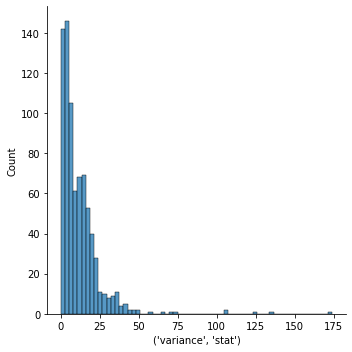

In [400]:
variables = img_modalities['smri'].columns
sns.displot(var_df.loc[variables, ('variance', 'stat')])

In [412]:
sex_diff = {}
for modality in img_modalities.keys():
    variables = img_modalities[modality].columns
    sex_diff[modality] = np.sum(var_df.loc[variables][('fligner_sex', 'p')] < 0.01) / len(variables)

In [413]:
sex_diff

{'smri': 0.1910828025477707,
 'fmri': 0.17678100263852242,
 'rsi': 0.040983606557377046,
 'dti': 0.16216216216216217}

In [176]:
# let's visualize this variability!
destrieux = datasets.fetch_atlas_surf_destrieux()
desikan = datasets.fetch_neurovault_ids(image_ids=(23262, ))

Reading local neurovault data.
No image found on local disk.
getting new batch: http://neurovault.org/api/images/23262
getting new batch: http://neurovault.org/api/collections/1446
Download succeeded, downloaded to: /Users/katherine.b/nilearn_data/neurovault/collection_1446/image_23262.nii.gz
Already fetched 1 image


In [347]:
atlas_to_abcd_thick = pd.DataFrame(columns=['label', 'abcd_var'])
l_and_r_destrieux = destrieux.labels * 2
for i in range(0, len(l_and_r_destrieux)):
    atlas_to_abcd_thick.at[i,'label'] = l_and_r_destrieux[i]
    if i == 0:
        atlas_to_abcd_thick.at[i,'abcd_var'] = np.nan
    elif i < 42:
        atlas_to_abcd_thick.at[i,'abcd_var'] = f'mrisdp_{i}'
    elif i == 42:
        atlas_to_abcd_thick.at[i,'abcd_var'] = np.nan
    elif 42 < i < 76:
        atlas_to_abcd_thick.at[i,'abcd_var'] = f'mrisdp_{i - 1}'
    elif i == 76:
        atlas_to_abcd_thick.at[i,'abcd_var'] = np.nan
    elif 76 < i < 116:
        atlas_to_abcd_thick.at[i,'abcd_var'] = f'mrisdp_{i - 2}'
    elif i == 116:
        atlas_to_abcd_thick.at[i,'abcd_var'] = np.nan
    elif i > 116:
        atlas_to_abcd_thick.at[i,'abcd_var'] = f'mrisdp_{i - 3}'

In [211]:
atlas_to_abcd_area = pd.DataFrame(columns=['label', 'abcd_var'])
l_and_r_destrieux = destrieux.labels * 2
for i in range(0, len(l_and_r_destrieux)):
    atlas_to_abcd_area.at[i,'label'] = l_and_r_destrieux[i]
    if i == 0:
        atlas_to_abcd_area.at[i,'abcd_var'] = np.nan
    elif i < 42:
        atlas_to_abcd_area.at[i,'abcd_var'] = f'mrisdp_{i+302}'
    elif i == 42:
        atlas_to_abcd_area.at[i,'abcd_var'] = np.nan
    elif 42 < i < 76:
        atlas_to_abcd_area.at[i,'abcd_var'] = f'mrisdp_{i + 301}'
    elif i == 76:
        atlas_to_abcd_area.at[i,'abcd_var'] = np.nan
    elif 76 < i < 116:
        atlas_to_abcd_area.at[i,'abcd_var'] = f'mrisdp_{i + 300}'
    elif i == 116:
        atlas_to_abcd_area.at[i,'abcd_var'] = np.nan
    elif i > 116:
        atlas_to_abcd_area.at[i,'abcd_var'] = f'mrisdp_{i + 299}'

In [368]:
# plot variance on a brain!

desikan_vol_nimg = nib.load(desikan.images[0])
desikan_vol_arra = destrieux_vol_nimg.get_fdata()
np.unique(desikan_vol_arra)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 118., 119., 120., 121., 122.,
       123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.,
       134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
       145., 146., 147., 148., 149., 150.])

In [215]:
subcort = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')


Dataset created in /Users/katherine.b/nilearn_data/fsl



Downloaded 21815296 of 25716861 bytes (84.8%,    0.7s remaining) ...done. (6 seconds, 0 min)
Extracting data from /Users/katherine.b/nilearn_data/fsl/7f20cb35336bbf6fcbcd4c1f1921cd10/HarvardOxford.tgz..... done.


In [263]:
scs = [np.nan,
       np.nan,
       np.nan,
       np.nan,
       "tplh",
       "cdlh",
       "ptlh",
       "pllh",
       "bs",
       "hclh",
       "aglh",
       "ablh",
       np.nan,
       np.nan,
       np.nan,
       "tprh",
       "cdrh",
       "ptrh",
       "plrh",
       "hcrh",
       "agrh",
       "abrh",
       np.nan]

In [278]:
scs_1 = ['x',
         'x',
         'x',
         'x',
        "tplh",
        "caudatelh",
        "putamenlh",
        "pallidumlh",
        "bstem",
        "hpuslh",
        "amygdalalh",
        "aal",
        'x',
        'x',
         'x',
        "tprh",
        "caudaterh",
        "putamenrh",
        "pallidumrh",
        "hpusrh",
        "amygdalarh",
        "aar"]

In [325]:
abcd_to_harvox = pd.DataFrame(columns=['label', 'Volume', 
                                       'T1w Intensity', 
                                       'Restricted Normalized Directional Diffusion', 
                                       'Restricted Normalized Isotropic Diffusion'])

for i in range(0, len(subcort.labels)):
    label = subcort.labels[i]
    abcd_to_harvox.at[i, 'label'] = label
    if scs_1[i] == 'x':
        abcd_to_harvox.at[i, 'Volume'] = np.nan
        abcd_to_harvox.at[i, 'T1w Intensity'] = np.nan
        abcd_to_harvox.at[i, 'Restricted Normalized Directional Diffusion'] = np.nan
        abcd_to_harvox.at[i, 'Restricted Normalized Isotropic Diffusion'] = np.nan
    else:
        abcd_to_harvox.at[i, 'Volume'] = f'smri_vol_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'T1w Intensity'] = f'smri_t1w_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'Restricted Normalized Directional Diffusion'] = f'dmri_rsirnd_scs_{scs[i]}'
        abcd_to_harvox.at[i, 'Restricted Normalized Isotropic Diffusion'] = f'dmri_rsirni_scs_{scs[i]}'

In [634]:
plotted_vars = []

<Figure size 432x288 with 0 Axes>

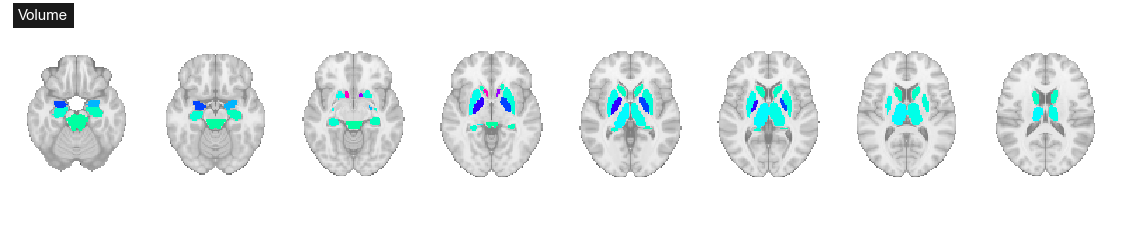

<Figure size 432x288 with 0 Axes>

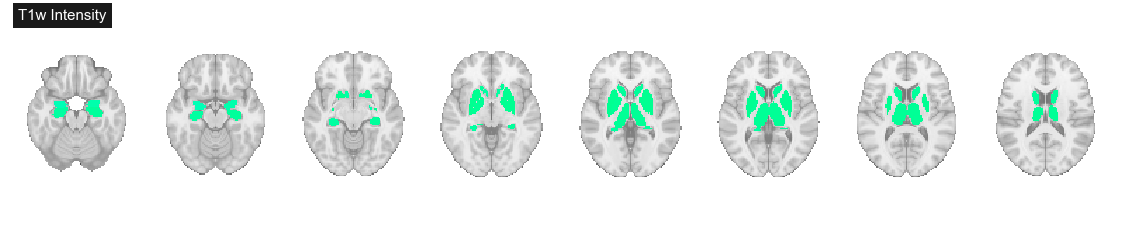

<Figure size 432x288 with 0 Axes>

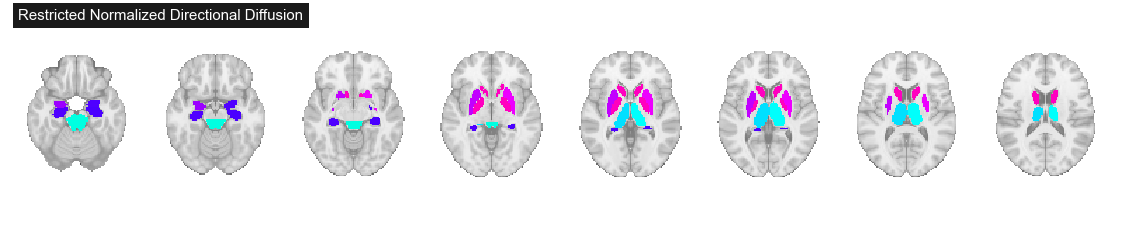

<Figure size 432x288 with 0 Axes>

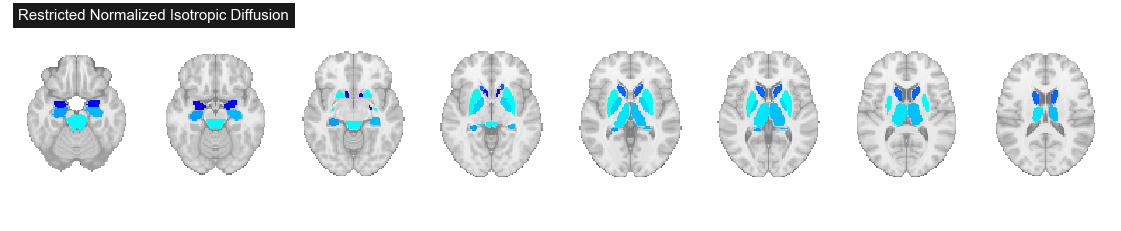

In [635]:
sc_array = subcort.filename.get_fdata()
for column in abcd_to_harvox.columns[1:]:
    plotting_arr = np.zeros(sc_array.shape)
    for i in abcd_to_harvox.index:
        abcd_var = abcd_to_harvox.loc[i, column]
        if column == 'Volume':
            plotted_vars.append(f'{abcd_var}.change_score')
        else:
            pass
        if abcd_var is np.nan:
            pass
        else:
            plotting_arr[np.where(sc_array == i)] = var_df.at[f'{abcd_var}.change_score',('variance', 'stat')]
    smri_vol_var_nimg = nib.Nifti1Image(plotting_arr, subcort.filename.affine)
    grid_kw = dict(width_ratios=[10,1])
    plt.figure(layout='tight')
    fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
    q = plotting.plot_stat_map(smri_vol_var_nimg, display_mode='z', 
                           cut_coords=[-20, -15, -10, -5, 0, 5, 10, 15], 
                           annotate=False, cmap='gist_rainbow', colorbar=False, title=column,
                           vmax=30., symmetric_cbar=False, threshold=0.1, axes=ax[0])

    ax[1].set_visible(False)
    q.savefig(f'{column}_variance.png', dpi=400)

In [636]:
fsaverage = datasets.fetch_surf_fsaverage()

In [637]:
destrieux_vol = datasets.fetch_atlas_destrieux_2009()

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [638]:
destrieux_vol_nimg = nib.load(destrieux_vol.maps)
destrieux_vol_arra = destrieux_vol_nimg.get_fdata()

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3760491434.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3760491434.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3760491434.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3760491434.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


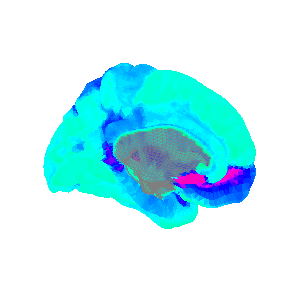

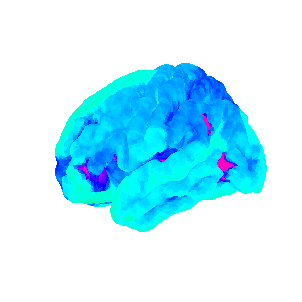

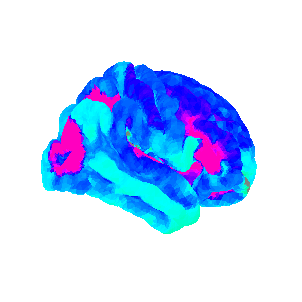

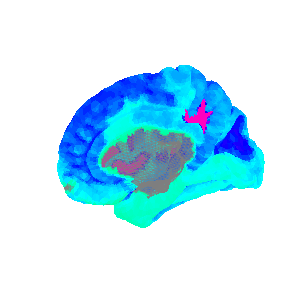

In [639]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_area.index:
    abcd_var = atlas_to_abcd_area.loc[i, 'abcd_var']
    plotted_vars.append(f'{abcd_var}.change_score')
    if abcd_var is np.nan:
        pass
    else:
        plotting_arr[np.where(destrieux_vol_arra == i)] = var_df.at[f'{abcd_var}.change_score',
                                                                    ('variance', 'stat')]
smri_area_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='medial', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_variance_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='lateral', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_variance_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='medial', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_variance_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='lateral', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_variance_rightlat.png', dpi=400)

In [640]:
from nilearn import surface

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3086913197.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3086913197.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3086913197.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3086913197.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


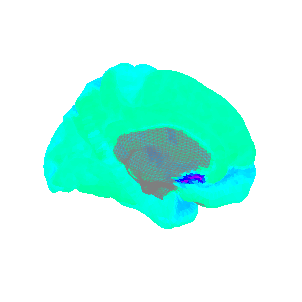

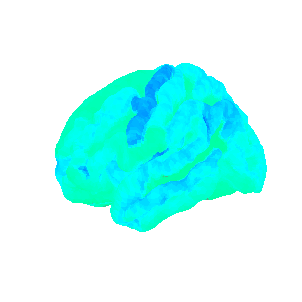

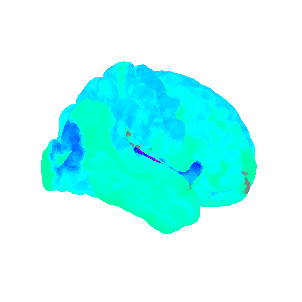

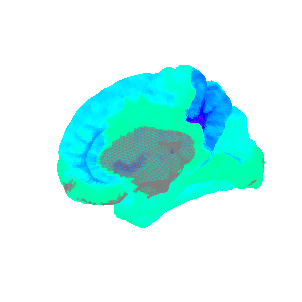

In [641]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_thick.loc[i, 'abcd_var']
    plotted_vars.append(f'{abcd_var}.change_score')
    if abcd_var is np.nan:
        pass
    else:
        plotting_arr[np.where(destrieux_vol_arra == i)] = var_df.at[f'{abcd_var}.change_score',
                                                                    ('variance', 'stat')]
smri_thick_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='medial', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_variance_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='lateral', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_variance_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='medial', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_variance_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='lateral', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_variance_rightlat.png', dpi=400)

In [642]:
sex_fligner_df = var_df[var_df[('fligner_sex', 'p')] < 0.01][('fligner_sex', 'diff')]

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3862882442.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3862882442.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3862882442.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3862882442.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


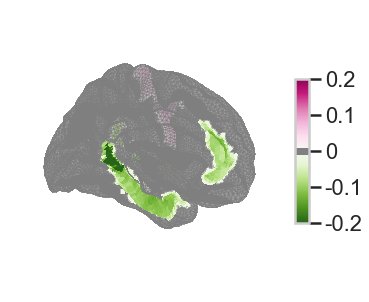

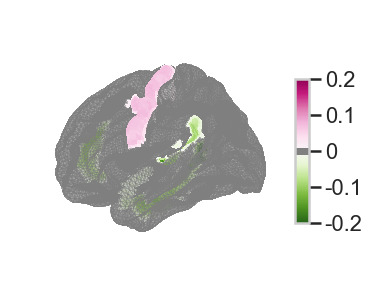

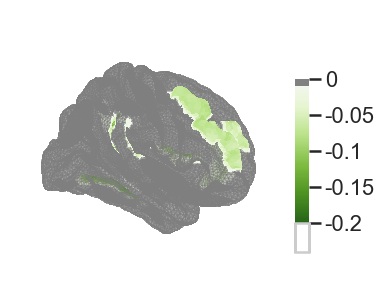

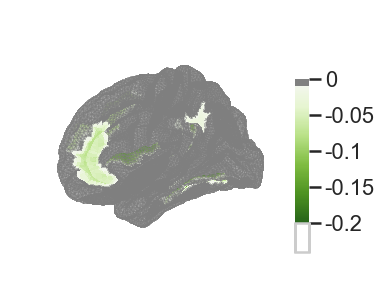

In [643]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_thick.loc[i, 'abcd_var']
    plotted_vars.append(f'{abcd_var}.change_score')
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = sex_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_thick_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, vmax=0.2,
                                     cmap='PiYG_r', view='medial', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_sexdifffligner_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l,  vmax=0.2,
                                     cmap='PiYG_r', view='lateral', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_sexdifffligner_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r,  vmax=0.2,
                                     cmap='PiYG_r', view='medial', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_sexdifffligner_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r,  vmax=0.2,
                                     cmap='PiYG_r', view='lateral', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_sexdifffligner_rightlat.png', dpi=400)

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3287176323.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3287176323.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3287176323.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_23091/3287176323.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


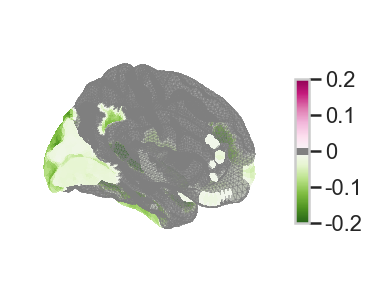

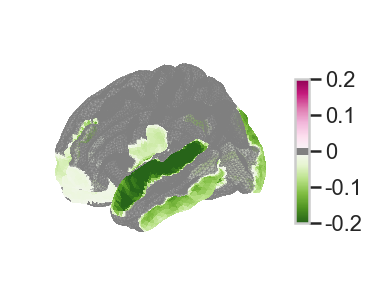

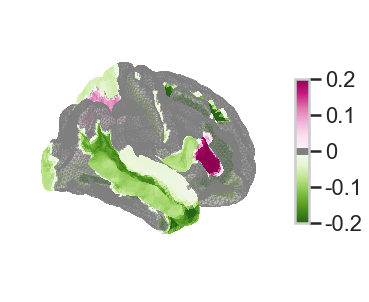

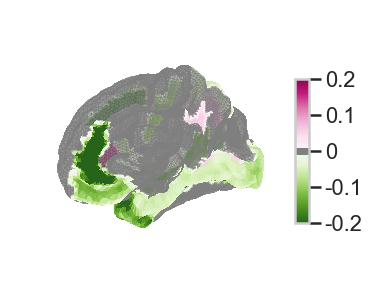

In [644]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_area.loc[i, 'abcd_var']
    plotted_vars.append(f'{abcd_var}.change_score')
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = sex_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_area_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, vmax=0.2,
                                     cmap='PiYG_r', view='medial', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_sexdifffligner_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l,  vmax=0.2,
                                     cmap='PiYG_r', view='lateral', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_sexdifffligner_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r,  vmax=0.2,
                                     cmap='PiYG_r', view='medial', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_sexdifffligner_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r,  vmax=0.2,
                                     cmap='PiYG_r', view='lateral', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_sexdifffligner_rightlat.png', dpi=400)

In [645]:
changes = []
for i in abcd_to_harvox['T1w Intensity'].unique()[1:]:
    changes.append(f'{i}.change_score')

In [646]:
var_df.loc[changes]

variance fligner_sex            \
                                          stat        stat         p   
smri_t1w_scs_tplh.change_score        0.520328    1.202798  0.272763   
smri_t1w_scs_caudatelh.change_score   0.864866    0.469886   0.49304   
smri_t1w_scs_putamenlh.change_score   0.448623    4.991762  0.025468   
smri_t1w_scs_pallidumlh.change_score  0.539621    2.898433  0.088666   
smri_t1w_scs_bstem.change_score       0.044225    1.320898  0.250431   
smri_t1w_scs_hpuslh.change_score      0.943657    1.976312   0.15978   
smri_t1w_scs_amygdalalh.change_score  1.970362    1.385574  0.239154   
smri_t1w_scs_aal.change_score         1.381725    2.104095  0.146905   
smri_t1w_scs_tprh.change_score        0.472136    0.393165   0.53064   
smri_t1w_scs_caudaterh.change_score   0.756525    0.045103  0.831814   
smri_t1w_scs_putamenrh.change_score   0.462059    0.001257  0.971716   
smri_t1w_scs_pallidumrh.change_score  0.419215     1.80479  0.179134   
smri_t1w_scs_hpusrh.change_score       0.88172    0.782586  0.376351   
smri_t1w_scs_amygdalarh.change_score  1.601398    2.713394  0.099509   
smri_t1w_scs_aar.change_score         1.058681    1.862001  0.172394   

                                                       fligner_puberty_m  \
                                          diff greater              stat   
smri_t1w_scs_tplh.change_score        0.022891       f          0.044086   
smri_t1w_scs_caudatelh.change_score  -0.023213       f          7.661654   
smri_t1w_scs_putamenlh.change_score   0.093842       f          0.106964   
smri_t1w_scs_pallidumlh.change_score  0.070916       f          2.047367   
smri_t1w_scs_bstem.change_score       0.012335       f           6.20648   
smri_t1w_scs_hpuslh.change_score     -0.016537       f          1.097021   
smri_t1w_scs_amygdalalh.change_score -0.017812       f          7.606184   
smri_t1w_scs_aal.change_score        -0.004649       f          5.705758   
smri_t1w_scs_tprh.change_score        0.046978       f          1.195672   
smri_t1w_scs_caudaterh.change_score   -0.01231       f          4.662264   
smri_t1w_scs_putamenrh.change_score   0.088723       f          2.924417   
smri_t1w_scs_pallidumrh.change_score  0.038088       f          0.157117   
smri_t1w_scs_hpusrh.change_score      0.006311       f          0.754618   
smri_t1w_scs_amygdalarh.change_score   0.00609       f          5.986289   
smri_t1w_scs_aar.change_score        -0.005215       f          3.831924   

                                                                       \
                                             p      diff      greater   
smri_t1w_scs_tplh.change_score        0.978198  0.061646  [[3, 2, 1]]   
smri_t1w_scs_caudatelh.change_score   0.021692  0.031749  [[2, 3, 1]]   
smri_t1w_scs_putamenlh.change_score   0.947923   0.02511  [[1, 3, 2]]   
smri_t1w_scs_pallidumlh.change_score  0.359269  0.031122  [[2, 1, 3]]   
smri_t1w_scs_bstem.change_score       0.044903  0.029916  [[1, 2, 3]]   
smri_t1w_scs_hpuslh.change_score       0.57781  0.121864  [[2, 1, 3]]   
smri_t1w_scs_amygdalalh.change_score  0.022302  0.104195  [[1, 2, 3]]   
smri_t1w_scs_aal.change_score         0.057678  0.021069  [[1, 2, 3]]   
smri_t1w_scs_tprh.change_score        0.550001  0.039409  [[1, 2, 3]]   
smri_t1w_scs_caudaterh.change_score   0.097186  0.106504  [[2, 1, 3]]   
smri_t1w_scs_putamenrh.change_score   0.231724  0.023672  [[2, 1, 3]]   
smri_t1w_scs_pallidumrh.change_score  0.924448   0.07802  [[2, 1, 3]]   
smri_t1w_scs_hpusrh.change_score      0.685704  0.100577  [[2, 1, 3]]   
smri_t1w_scs_amygdalarh.change_score   0.05013  0.057399  [[1, 3, 2]]   
smri_t1w_scs_aar.change_score           0.1472  0.099716  [[2, 1, 3]]   

                                     fligner_puberty_f  ... fligner_raceth  \
                                                  stat  ...           stat   
smri_t1w_scs_tplh.change_score                 5.49793  ...     233.961855   
smri_t1w_scs_caudatelh.change_score         

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


<Figure size 432x288 with 0 Axes>

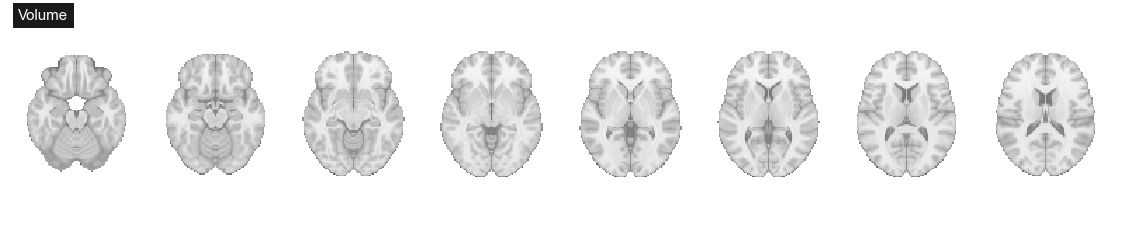

<Figure size 432x288 with 0 Axes>

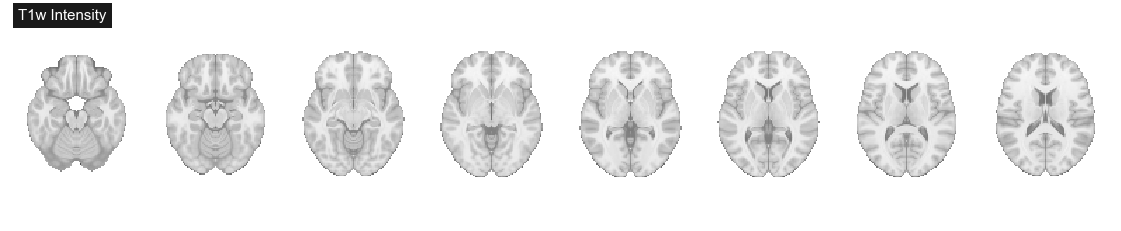

<Figure size 432x288 with 0 Axes>

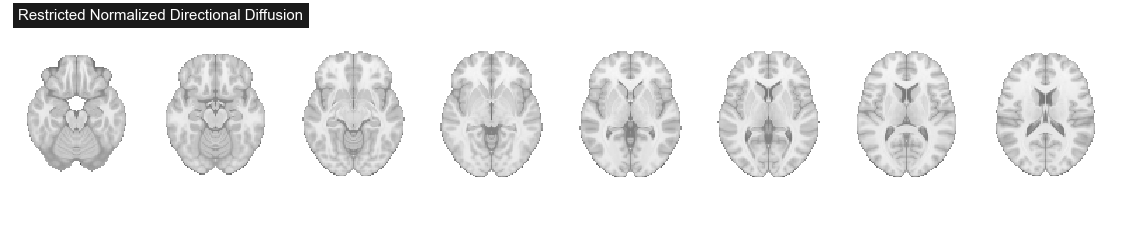

<Figure size 432x288 with 0 Axes>

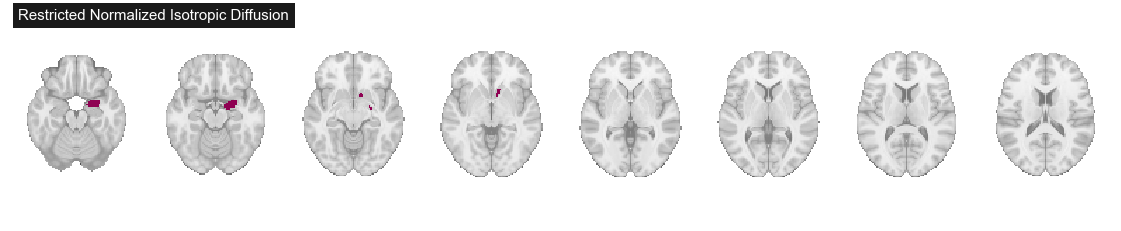

In [647]:
for column in abcd_to_harvox.columns[1:]:
    plotting_arr = np.zeros(sc_array.shape)
    for i in abcd_to_harvox.index:
        abcd_var = abcd_to_harvox.loc[i, column]
        if column == 'Volume':
            plotted_vars.append(f'{abcd_var}.change_score')
        else:
            pass
        if abcd_var is np.nan:
            pass
        else:
            try:
                plotting_arr[np.where(sc_array == i)] = sex_fligner_df.loc[f'{abcd_var}.change_score']
            except:
                plotting_arr[np.where(sc_array == i)] = 0
    smri_vol_var_nimg = nib.Nifti1Image(plotting_arr, subcort.filename.affine)
    grid_kw = dict(width_ratios=[10,1])
    plt.figure(layout='tight')
    fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
    q = plotting.plot_stat_map(smri_vol_var_nimg, display_mode='z', 
                           cut_coords=[-20, -15, -10, -5, 0, 5, 10, 15], 
                           annotate=False, cmap='PiYG_r', colorbar=False, title=column,
                           vmax=0.2, symmetric_cbar=False, threshold=0.1, axes=ax[0])

    ax[1].set_visible(False)
    q.savefig(f'{column}_sexdifffligner.png', dpi=400)

In [670]:
plotted_vars = list(np.unique(plotted_vars))

In [671]:
pvar_f = pd.DataFrame(index=plotted_vars, 
                    columns=['highest', 
                             'middle', 
                             'lowest'])

for i in pvar_f.index:
    pvar_f.at[i, 'highest'] = int(var_df.loc[i, ('fligner_puberty_f', 'greater')][0][0])
    pvar_f.at[i, 'middle'] = int(var_df.loc[i, ('fligner_puberty_f', 'greater')][0][1])
    pvar_f.at[i, 'lowest'] = int(var_df.loc[i, ('fligner_puberty_f', 'greater')][0][2])

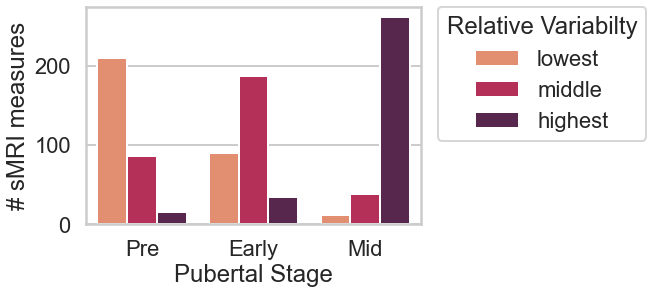

In [672]:
sns.set_style('whitegrid')
sns.set_context('poster')
fig,ax = plt.subplots()
sns.countplot(x='value', hue='variable', 
              hue_order=['lowest', 'middle', 'highest'], 
              data=pd.melt(pvar_f), palette='rocket_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Relative Variabilty')
ax.set_xticklabels(['Pre', 'Early', 'Mid'])
ax.set_xlabel('Pubertal Stage')
ax.set_ylabel('# sMRI measures')
fig.savefig('pubertal_variability_f.png', dpi=400, bbox_inches='tight')

In [675]:
pvar_m = pd.DataFrame(index=plotted_vars, 
                    columns=['highest', 
                             'middle', 
                             'lowest'])

for i in pvar_m.index:
    pvar_m.at[i, 'highest'] = int(var_df.loc[i, ('fligner_puberty_m', 'greater')][0][0])
    pvar_m.at[i, 'middle'] = int(var_df.loc[i, ('fligner_puberty_m', 'greater')][0][1])
    pvar_m.at[i, 'lowest'] = int(var_df.loc[i, ('fligner_puberty_m', 'greater')][0][2])

In [679]:
np.sum(pvar_m['lowest'] == 1)

119

In [707]:
from statsmodels.stats import contingency_tables
contingency = np.zeros((2,3))
#contingency[0][0] = np.sum(pvar_m['lowest'] == 1)
#contingency[0][1] = np.sum(pvar_m['middle'] == 1)
#contingency[0][2] = np.sum(pvar_m['highest'] == 1)
contingency[1][0] = np.sum(pvar_m['lowest'] == 2)
contingency[1][1] = np.sum(pvar_m['middle'] == 2)
contingency[1][2] = np.sum(pvar_m['highest'] == 2)
contingency[0][0] = np.sum(pvar_m['lowest'] == 3)
contingency[0][1] = np.sum(pvar_m['middle'] == 3)
contingency[0][2] = np.sum(pvar_m['highest'] == 3)
m_by_puberty_diff = contingency_tables.cochrans_q(contingency) 
print(contingency, '\n\n', m_by_puberty_diff)

[[107.  46. 158.]
 [ 85. 151.  75.]] 

 df          2
pvalue      0.36787944117144245
statistic   2.0


In [706]:
contingency = np.zeros((2,3))
#contingency[0][0] = np.sum(pvar_f['lowest'] == 1)
#contingency[0][1] = np.sum(pvar_f['middle'] == 1)
#contingency[0][2] = np.sum(pvar_f['highest'] == 1)
contingency[1][0] = np.sum(pvar_f['lowest'] == 2)
contingency[1][1] = np.sum(pvar_f['middle'] == 2)
contingency[1][2] = np.sum(pvar_f['highest'] == 2)
contingency[0][0] = np.sum(pvar_f['lowest'] == 3)
contingency[0][1] = np.sum(pvar_f['middle'] == 3)
contingency[0][2] = np.sum(pvar_f['highest'] == 3)
f_by_puberty_diff = contingency_tables.cochrans_q(contingency) 
print(contingency, '\n\n', f_by_puberty_diff)

[[ 12.  38. 261.]
 [ 90. 187.  34.]] 

 df          2
pvalue      0.36787944117144245
statistic   2.0


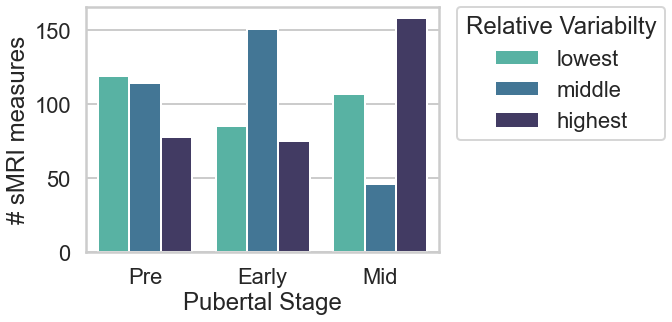

In [676]:
sns.set_style('whitegrid')
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(10,5))
sns.countplot(x='value', hue='variable', 
              hue_order=['lowest', 'middle', 'highest'], 
              data=pd.melt(pvar_m), palette='mako_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Relative Variabilty')
ax.set_xticklabels(['Pre', 'Early', 'Mid'])
ax.set_xlabel('Pubertal Stage')
ax.set_ylabel('# sMRI measures')
plt.tight_layout()
fig.savefig('pubertal_variability_m.png', dpi=400, bbox_inches='tight')

In [ ]:
contingency = pd.DataFrame(columns=['M', 'F'],
                           index=[1, 2, 3])

for i in contingency.index:
    contingency.at[i, 'M'] = 
contingency.at[1,0] = table.loc['RE_White', 'whole_sample']
contingency[0,1] = table.loc['RE_Black', 'whole_sample']
contingency[0,2] = table.loc['RE_Hispanic', 'whole_sample']
contingency[0,3] = table.loc['RE_Asian', 'whole_sample']
contingency[0,4] = table.loc['RE_Other', 'whole_sample']
contingency[1,0] = table.loc['RE_White', 'with_2yfu']
contingency[1,1] = table.loc['RE_Black', 'with_2yfu']
contingency[1,2] = table.loc['RE_Hispanic', 'with_2yfu']
contingency[1,3] = table.loc['RE_Asian', 'with_2yfu']
contingency[1,4] = table.loc['RE_Other', 'with_2yfu']
out = contingency_tables.cochrans_q(contingency) 
table.at['RE_White', 'Stat'] = out.statistic
table.at['RE_White', 'p(Stat)'] = out.pvalue

In [542]:
fpu_fligner_df = var_df[var_df[('fligner_puberty_f', 'p')] < 0.01][('fligner_puberty_f', 'diff')]
mpu_fligner_df = var_df[var_df[('fligner_puberty_m', 'p')] < 0.01][('fligner_puberty_m', 'diff')]

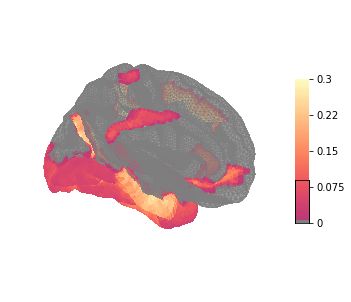

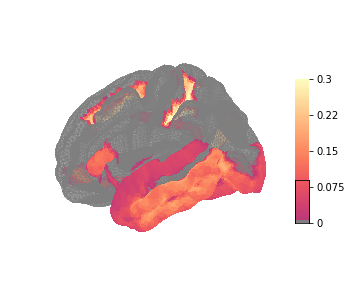

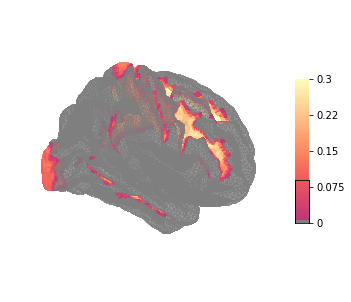

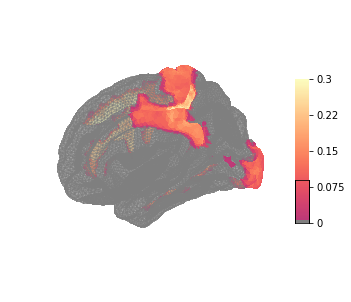

In [551]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_thick.loc[i, 'abcd_var']
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = fpu_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_thick_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_pubertydifff_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_pubertydifff_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_pubertydifff_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_pubertydifff_rightlat.png', dpi=400)

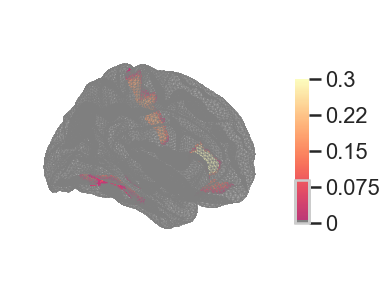

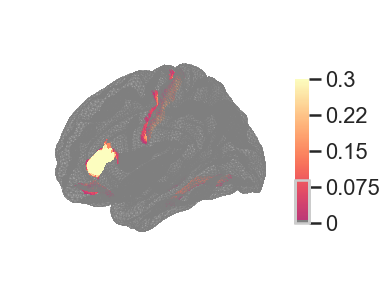

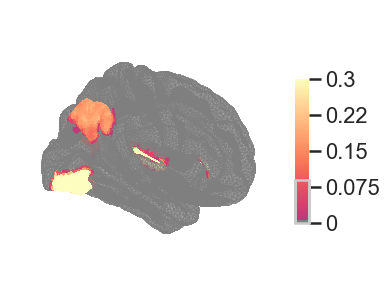

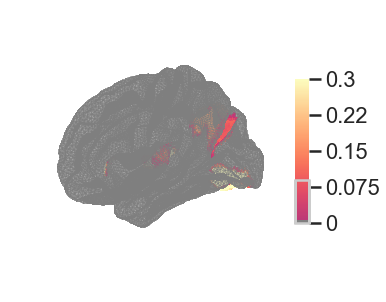

In [628]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_area.loc[i, 'abcd_var']
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = fpu_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_area_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_pubertydifff_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_pubertydifff_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_pubertydifff_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_pubertydifff_rightlat.png', dpi=400)

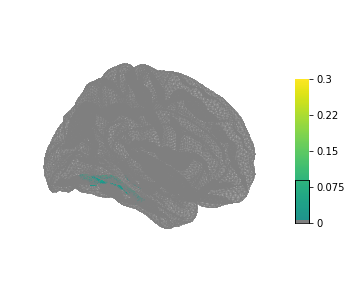

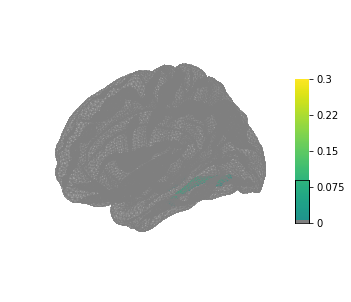

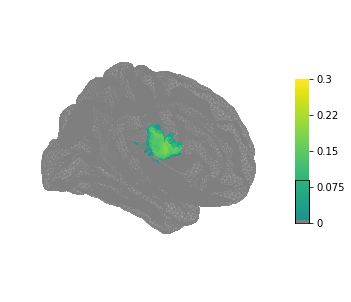

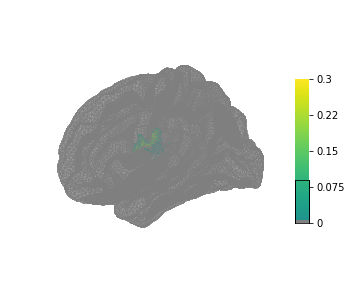

In [557]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_thick.loc[i, 'abcd_var']
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = mpu_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_thick_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_pubertydiffm_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_pubertydiffm_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_pubertydiffm_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_thickness_pubertydiffm_rightlat.png', dpi=400)

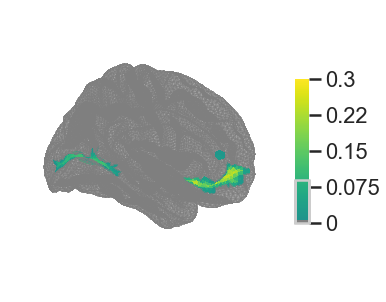

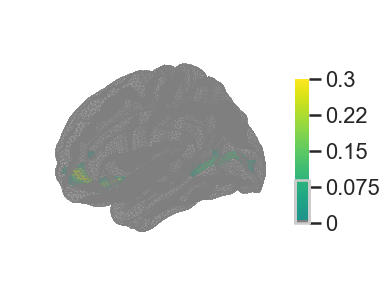

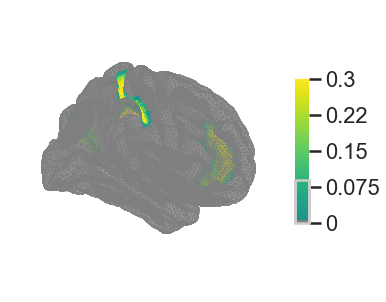

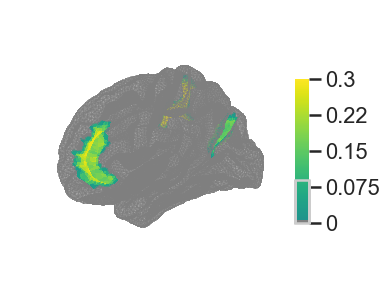

In [629]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_area.loc[i, 'abcd_var']
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = mpu_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_area_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_pubertydiffm_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_pubertydiffm_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_pubertydiffm_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig(f'cortical_area_pubertydiffm_rightlat.png', dpi=400)

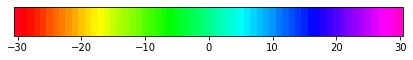

In [424]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap='gist_rainbow', 
                               values=range(-30,31), )

plt.savefig('gist_rainbow.png', bbox_inches='tight', dpi=400)